In [6]:
import sys
import os
import json
import matplotlib.pyplot as plt

import dysts
from dysts.datasets import *

from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

from darts.models import *
from darts import TimeSeries
import darts.models

from degas import *
set_style()


# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

Importing plotly failed. Interactive plots will not work.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
darts.metrics.mape(
    TimeSeries.from_dataframe(pd.DataFrame(np.zeros(100) + 1e-5)), 
    TimeSeries.from_dataframe(pd.DataFrame(np.random.random(100) - 10))
)

95030724.70290324

### Tune hyperparameters on train

In [49]:
%%bash --out output --err error

python3 find_hyperparameters.py

Process is terminated.


### Run and record forecasts on test

In [73]:
%%bash --out output --err error

python3 compute_benchmarks.py

Process is terminated.


## Make predictions

In [8]:
import dysts
import os
import json



'/Users/williamgilpin/miniconda3/envs/dysts/lib/python3.8/site-packages/dysts/data'

In [40]:
from dysts.datasets import load_file

data_dynamics = load_file(os.path.dirname(dysts.data_path) + "/test_univariate__pts_per_period_100__periods_12.json")

import json
with open("../benchmarks/hyperparameters/hyperparameters_train_univariate__pts_per_period_100__periods_12.json", "r") as file:
    all_hyperparams = json.load(file)

In [43]:
all_hyperparams["SprottD"]["ARIMA"]


{'p': 10}

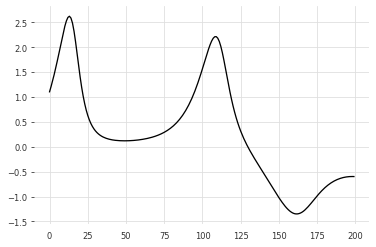

In [37]:
plt.plot(data_dynamics["Bouali"]["values"][-200:])

In [163]:
import os
import json
with open(os.getcwd() + "/results/results_test_univariate__pts_per_period_100__periods_12.json", "r") as file:
    all_results = json.load(file)

all_results.keys()

## get best models
all_best_models = list()
for equation_name in all_results:
    all_models = list()
    all_smapes = list()
    for model_name in all_results[equation_name]:
        if model_name != "values":
            all_models.append(model_name)
            all_smapes.append(all_results[equation_name][model_name]["smape"])
    all_best_models.append(all_models[np.argmin(all_smapes)])
    
all_results_transposed = dict()
for model_name in all_results["Lorenz"]:
    if model_name == "values":
        continue
    all_results_transposed[model_name] = dict()
for equation_name in all_results:
    for model_name in all_results[equation_name]:
        if model_name == "values":
            continue
        all_results_transposed[model_name][equation_name] = all_results[equation_name][model_name]

        
hist_values = dict()
for model_name in all_results_transposed:
    smape_vals = list()
    for key in  all_results_transposed[model_name]:
        smape_vals.append(all_results_transposed[model_name][key]["smape"])
        
    hist_values[model_name] = smape_vals.copy()

In [164]:
# hist_values_low = hist_values.copy()
# hist_values_high = hist_values.copy()

In [132]:
# all_results_transposed["ARIMA"]

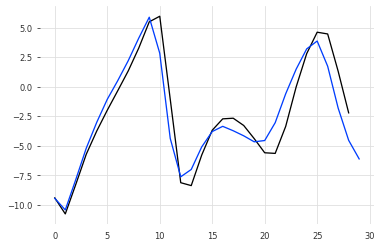

In [151]:
plt.plot(all_results["Halvorsen"]["values"])
plt.plot(all_results["Halvorsen"]["NBEATSModel"]["prediction"])

In [7]:
def violin_horizontal(x, y1, y2):
    """Create a horizonal violin plot"""
    
    plt.bar(x, y1)
    plt.bar(x, -y2)

vals, bins = np.histogram(counts)
violin_horizontal( bins[1:], vals, vals)
    

NameError: name 'counts' is not defined

In [179]:
import degas as dg
dg.set_style()

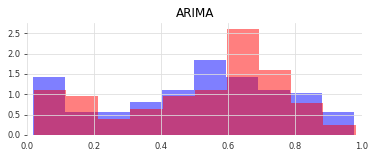

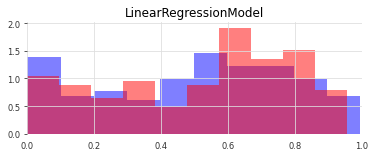

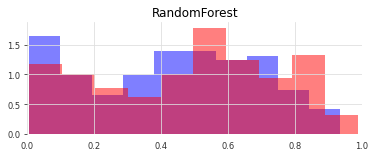

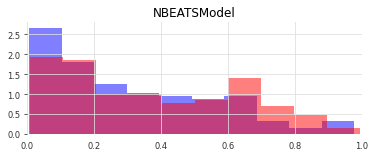

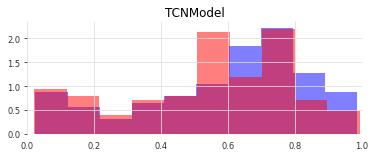

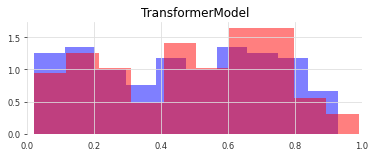

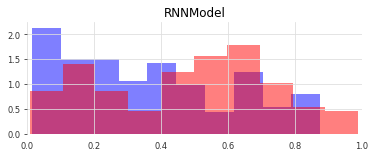

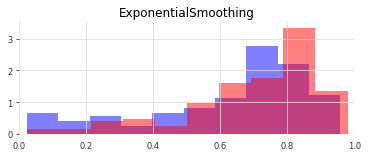

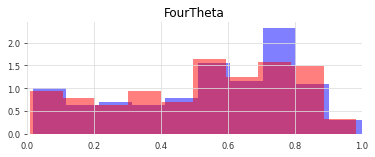

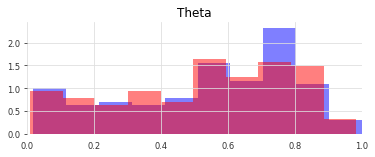

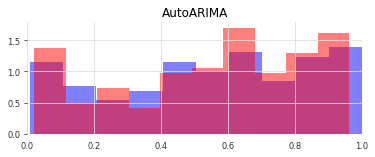

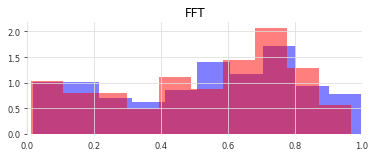

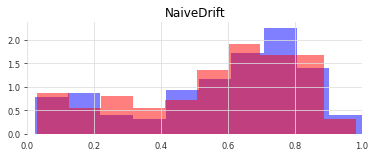

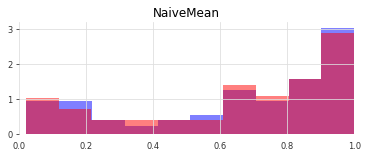

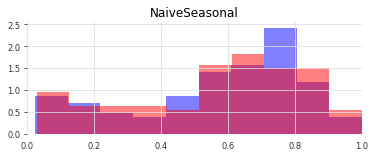

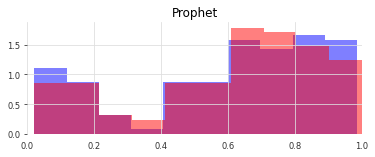

In [180]:
for model_name in hist_values_low:
    
    plt.figure()
    counts = np.array(hist_values_low[model_name]) / 200.
    plt.hist(counts, 10, density=True, color="b", alpha=0.5);
    counts = np.array(hist_values_high[model_name]) / 200.
    plt.hist(counts, 10, density=True, color="r", alpha=0.5);
    plt.title(model_name)
    plt.xlim([0, 1])
    fixed_aspect_ratio(1/3)
    

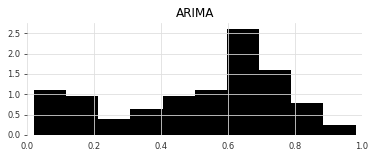

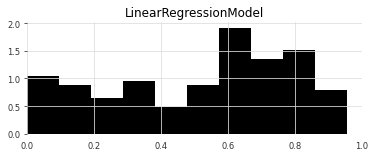

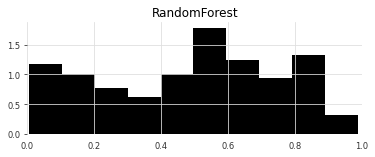

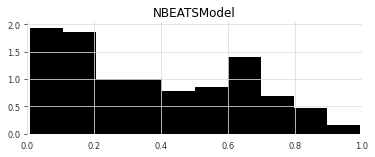

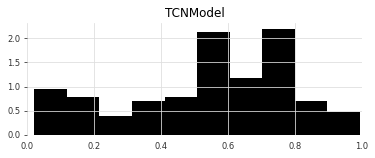

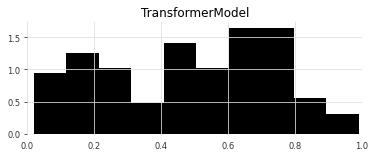

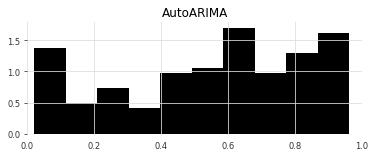

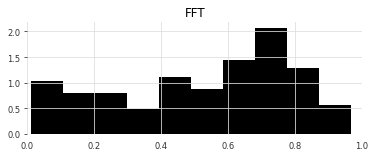

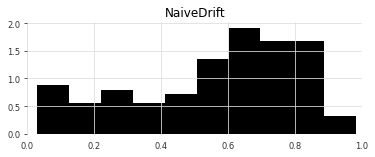

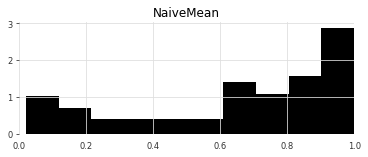

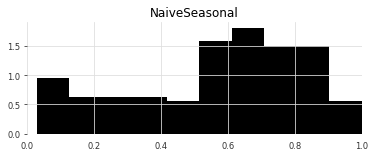

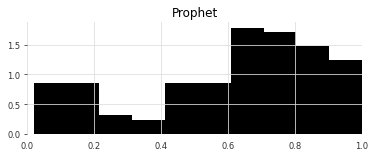

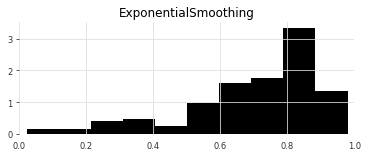

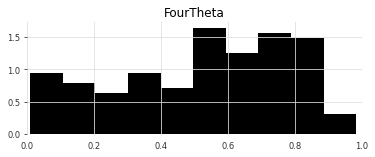

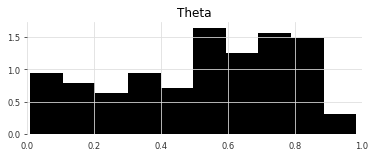

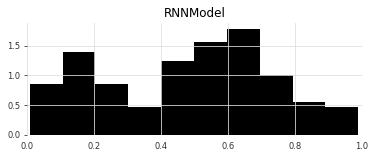

In [138]:
for item in hist_values:
    counts = np.array(hist_values[item]) / 200.
    plt.figure()
    plt.hist(counts, 10, density=True);
    plt.title(item)
    plt.xlim([0, 1])
    fixed_aspect_ratio(1/3)
    

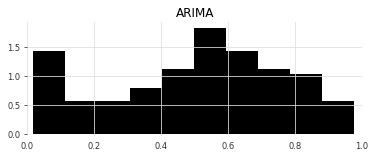

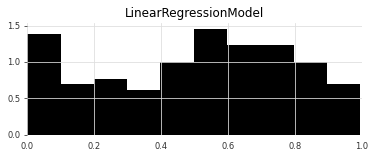

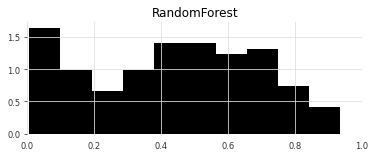

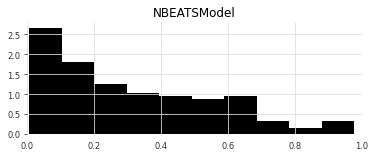

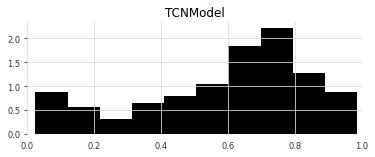

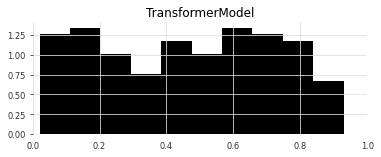

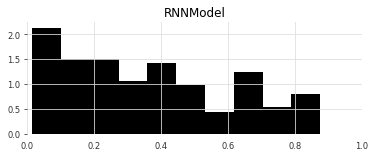

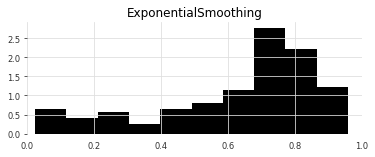

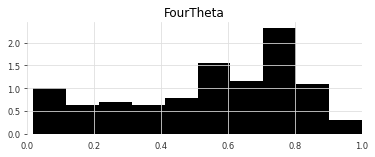

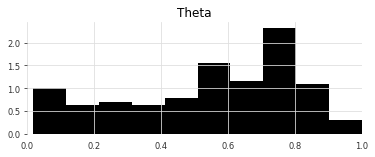

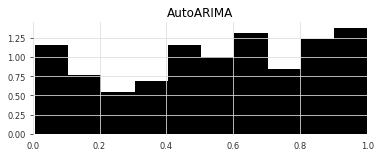

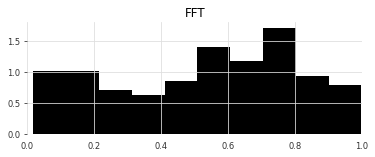

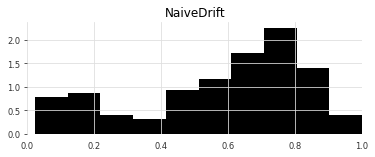

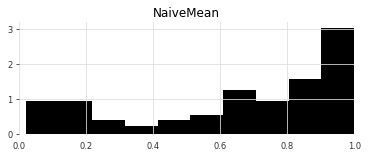

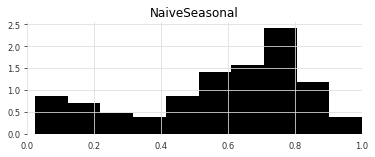

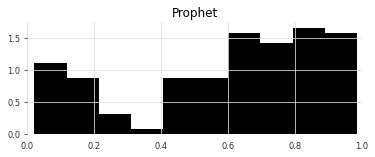

In [161]:
for item in hist_values:
    counts = np.array(hist_values[item]) / 200.
    plt.figure()
    plt.hist(counts, 10, density=True);
    plt.title(item)
    plt.xlim([0, 1])
    fixed_aspect_ratio(1/3)
    

In [108]:
model_ranks = sorted([(item, all_best_models.count(item)) for item in np.unique(all_best_models)], key=lambda x : x[1])
model_names_sorted = [item[0] for item in model_ranks]

In [109]:
model_ranks

[('ExponentialSmoothing', 1),
 ('NaiveSeasonal', 1),
 ('Prophet', 1),
 ('Theta', 2),
 ('FourTheta', 4),
 ('NaiveDrift', 4),
 ('AutoARIMA', 5),
 ('LinearRegressionModel', 6),
 ('FFT', 7),
 ('RandomForest', 7),
 ('TCNModel', 8),
 ('TransformerModel', 13),
 ('RNNModel', 17),
 ('NBEATSModel', 55)]

In [ ]:
## Plots of example fits / trajectories for the hardest



In [ ]:
## Plots of confusion

ExponentialSmoothing
NaiveSeasonal
Prophet
Theta
FourTheta
NaiveDrift
AutoARIMA
LinearRegressionModel
FFT
RandomForest
TCNModel
TransformerModel
RNNModel
NBEATSModel


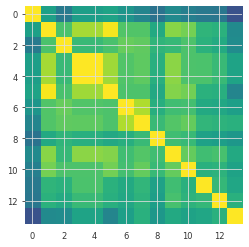

In [117]:
df_sorted = pd.DataFrame(hist_values)[model_names_sorted]
ccm = df_sorted.corr(method="pearson")
plt.imshow(ccm.to_numpy(), vmin=0.0, vmax=1.0)
print("\n".join(model_names_sorted))

In [ ]:
## hardest and easiest dynamics to classify 

In [18]:


hist_values = dict()
    
for model_name in all_results["Lorenz"]:
    
    if model_name == "values":
        continue
    hist_values[model_name] = list()
    for equation_name in all_results:
        hist_values[model_name].append(all_results[equation_name][model_name]["smape"])

# for equation_name in all_results:
#     all_models = list()
#     all_smapes = list()
#     for model_name in all_results[equation_name]:
#         if model_name != "values":
#             all_models.append(model_name)
#             all_smapes.append(all_results[equation_name][model_name]["smape"])
#     all_best_models.append(all_models[np.argmin(all_smapes)])

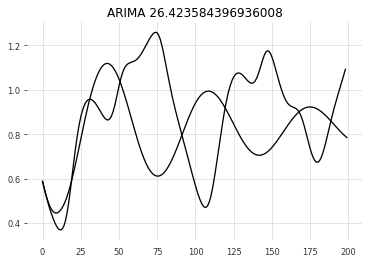

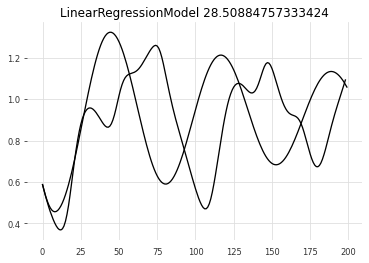

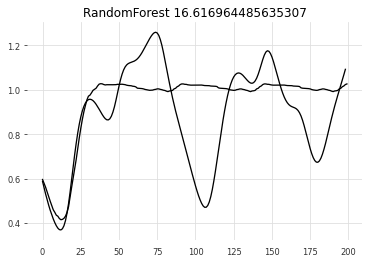

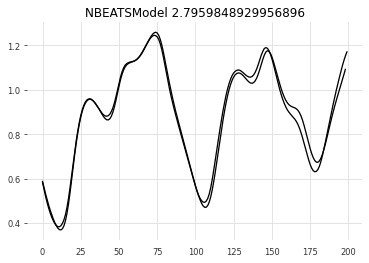

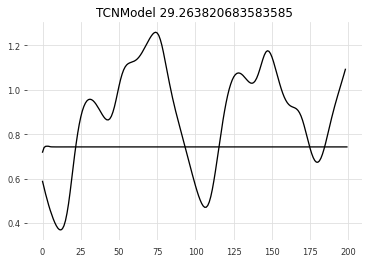

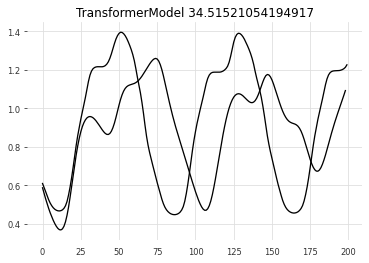

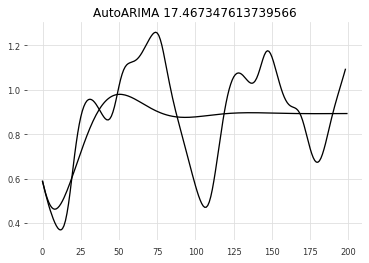

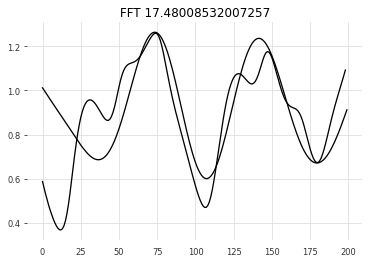

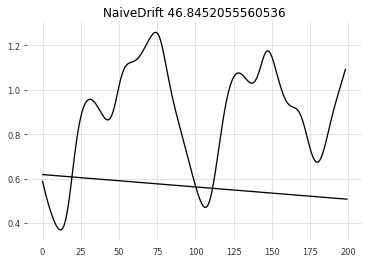

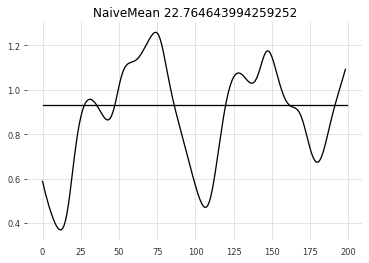

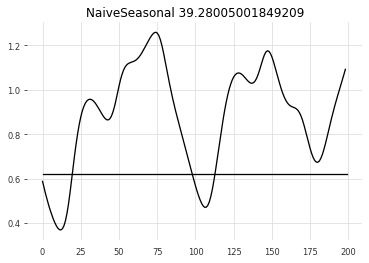

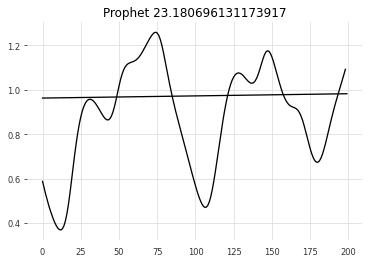

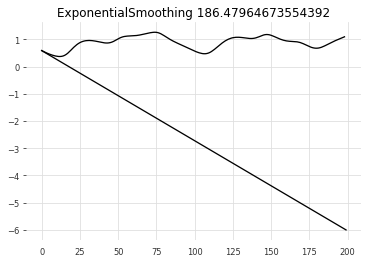

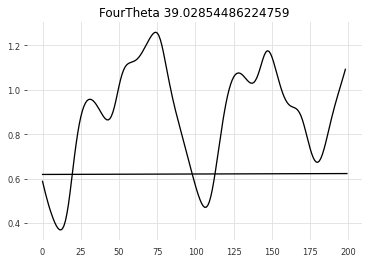

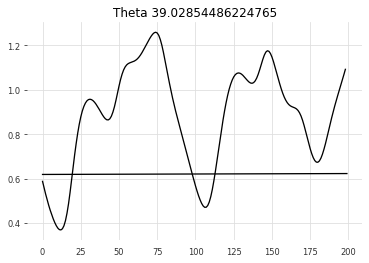

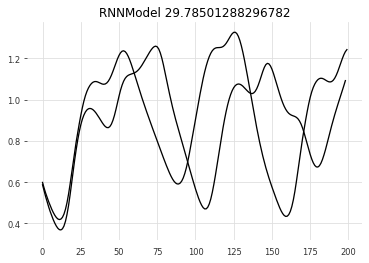

In [5]:

equation_name = "MackeyGlass"
for item in all_results[equation_name]:
    if item != "values":
        plt.figure()
        plt.plot(np.array(all_results[equation_name][item]["prediction"]))
        plt.plot(np.array(all_results[equation_name]["values"]), 'k')
        plt.title(item + " " + str(all_results[equation_name][item]["smape"]))
        

In [9]:
# import dysts.base

# dysts.base.get_attractor_list()

In [118]:
input_path = os.path.dirname(cwd)  + "/dysts/data/test_univariate__pts_per_period_100__periods_12.json"

In [129]:
dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]
dataname = dataname.replace("test", "train" )
output_path

'/Users/williamgilpin/program_repos/dysts/benchmarks/hyperparameters/hyperparameters_train_univariate__pts_per_period_100__periods_12.json'

In [105]:
for item in all_results:
    print(item)

Aizawa


In [110]:

 

for item in all_results:
    for item2 in all_results[item]:
        print(all_results[item][item2]["mape"], all_results[item][item2]["smape"])
        

152.92074421072743 76.13904181075483
39.30402544754412 33.89830988506473
165.00341205004094 114.82504832531686
11.67602440464197 10.0407280130207
67.4879941952164 87.11865647613067


KeyError: 'mape'

In [103]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# y = load_airline()
y_train, y_test = temporal_train_test_split(train_data, train_size=split_point)
t_train, t_test = temporal_train_test_split(np.arange(len(train_data)), train_size=split_point)
# fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = AutoETS()  # monthly seasonal periodicity
forecaster.fit(pd.Series(y_train))
# y_pred = forecaster.predict(fh)
y_pred = np.array(forecaster.predict(np.arange(len(val))))

In [ ]:
from darts.metrics.metrics import smape, mape, mase

In [194]:
?darts.metrics.metrics.ope

Signature:
darts.metrics.metrics.ope(
    actual_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]],
    pred_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]],
    intersect: bool = True,
    *,
    reduction: Callable[[numpy.ndarray], float] = <function mean at 0x7fc970248a60>,
    inter_reduction: Callable[[numpy.ndarray], Union[float, numpy.ndarray]] = <function <lambda> at 0x7fc9c124d3a0>,
    n_jobs: int = 1,
    verbose: bool = False,
) -> Union[float, numpy.ndarray]
Docstring:
Overall Percentage Error (OPE).

Given a time series of actual values :math:`y_t` and a time series of predicted values :math:`\hat{y}_t`
both of length :math:`T`, it is a percentage value computed as

.. math:: 100 \cdot \left| \frac{\sum_{t=1}^{T}{y_t}
          - \sum_{t=1}^{T}{\hat{y}_t}}{\sum_{t=1}^{T}{y_t}} \right|.

Parameters
----------
actual_series
    The `TimeSeries` or `Sequence[TimeSeries]` of actual values.
pred_series
    The `

In [179]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [158]:


darts.metrics.metrics.r2_score(true_y, pred_y)

0.046834373885299985

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    MASE (Mean Absolute Scaled Error)
    """
#     if y_train.ndim == 1: y_train = np.expand_dims(y_train, 1)

    # naive seasonal prediction
    y_train = np.asarray(y_train)
    y_pred_naive = y_train
    
    y_train = np.squeeze(y_train.values())

    # mean absolute error of naive seasonal prediction
    mae_naive = darts.metrics.metrics.mae(y_train[1:], y_train[:-1])

    mae_pred = darts.metrics.metrics.mae(
        y_true, y_pred, horizon_weight=horizon_weight, multioutput=multioutput
    )
    return mae_pred / np.max([mae_naive, 1e-15])


In [200]:
import darts.metrics.metrics
dir(darts.metrics.metrics)

all_metrics = {
    'coefficient_of_variation',
    'mae',
    'mape',
    'marre',
#     'mase', # extremely hard to calculate, since it scales relative to another dataset
    'mse',
#     'ope', # runs into issues with zero handling
    'r2_score',
    'rmse',
    'rmsle',
    'smape'
}

pred_y = TimeSeries.from_dataframe(pd.DataFrame(np.array(all_predictions["TransformerModel"])))
true_y = TimeSeries.from_dataframe(pd.DataFrame(y_train_val[:-1]))

for metric_name in all_metrics:
    if metric_name == "mase":
        metric_func = lambda x, y : darts.metrics.metrics.mase(x, y, insample=train_ts)
    else:
        metric_func = getattr(darts.metrics.metrics, metric_name)
    
    metric_func(true_y, pred_y)
# def compute_all_metrics()

[2021-06-12 05:44:59,836] ERROR | darts.metrics.metrics | ValueError: The series of actual value cannot sum to zero when computing OPE.
ERROR:darts.metrics.metrics:ValueError: The series of actual value cannot sum to zero when computing OPE.


ValueError: The series of actual value cannot sum to zero when computing OPE.

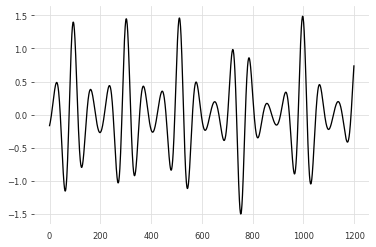

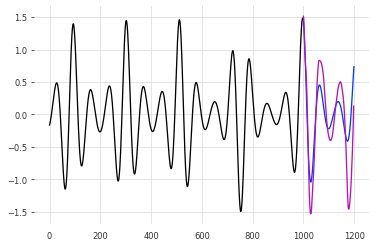

In [142]:
plt.plot(t_train, y_train)
plt.plot(t_train_val, y_train_val)
plt.plot(t_train_val[:-1], all_predictions["TransformerModel"])

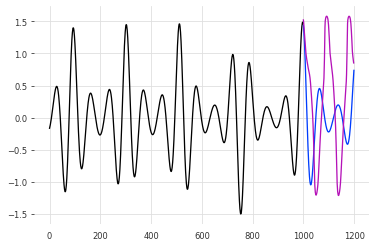

In [140]:
plt.plot(t_train, y_train)
plt.plot(t_train_val, y_train_val)
plt.plot(t_train_val[:-1], all_predictions["TransformerModel"])

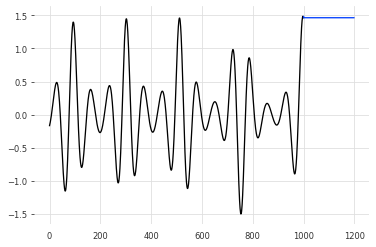

In [124]:
plt.plot(t_train, y_train)
# plt.plot(all_predictions)

# for pred in all_predictions:
plt.plot(t_test[:-1], y_pred)

In [ ]:

names = 
models =
metrics =
benchmark_forecasts = pd.DataFrame

In [ ]:
ModelMode.ADDITIVE

In [3]:
import darts.models

Importing plotly failed. Interactive plots will not work.


In [95]:
all_predictions[0]

IndexError: list index out of range

In [62]:
len(val)

199

In [175]:
 train_data[split_point:].shape

(200,)

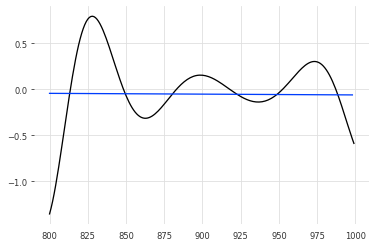

In [190]:
plt.plot(np.arange(split_point, 1000), train_data[split_point:])
plt.plot(np.arange(split_point, 999), all_predictions[-4])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1200,)

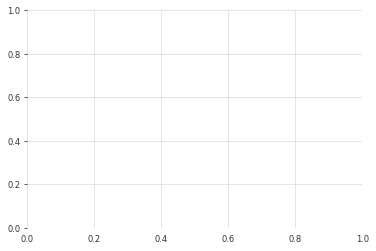

In [123]:
plt.plot(np.arange(1000), train_data)
# plt.plot(all_predictions)

for pred in all_predictions:
    plt.plot(np.arange(split_point, 999), pred)
    


In [34]:
?train_df.split_after

Signature:
train_df.split_after(
    split_point: Union[pandas._libs.tslibs.timestamps.Timestamp, float, int],
) -> Tuple[ForwardRef('TimeSeries'), ForwardRef('TimeSeries')]
Docstring:
Splits the TimeSeries in two, after a provided `split_point`.

Parameters
----------
split_point
    A timestamp, float or integer. If float, represents the proportion of the dataset to include in the
    first TimeSeries (must be between 0.0 and 1.0). If integer, represents the index position after
    which the split is performed. If timestamp, it will be contained in the first TimeSeries, but not
    in the second one. The timestamp may not appear in the original TimeSeries index.

Returns
-------
Tuple[TimeSeries, TimeSeries]
    A tuple of two time series. The first time series contains the first samples up to the `split_point`,
    and the second contains the remaining ones.
File:      ~/miniconda3/envs/nn/lib/python3.8/site-packages/darts/timeseries.py
Type:      method


In [29]:
pd.DataFrame(np.vstack([np.arange(len(train_data)), train_data]).T, columns=["time", "vals"])


,0,1
0,0.0,0.353756
1,1.0,0.353819
2,2.0,0.350929
3,3.0,0.344973
4,4.0,0.335860
...,...,...
995,995.0,-0.389878
996,996.0,-0.441711
997,997.0,-0.492419
998,998.0,-0.541439


In [9]:
from darts import TimeSeries
import pandas as pd
# series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

                                      0
1970-01-01 00:00:00.000000000  0.353756
1970-01-01 00:00:00.000000001  0.353819
1970-01-01 00:00:00.000000002  0.350929
1970-01-01 00:00:00.000000003  0.344973
1970-01-01 00:00:00.000000004  0.335860
...                                 ...
1970-01-01 00:00:00.000000995 -0.389878
1970-01-01 00:00:00.000000996 -0.441711
1970-01-01 00:00:00.000000997 -0.492419
1970-01-01 00:00:00.000000998 -0.541439
1970-01-01 00:00:00.000000999 -0.588207

[1000 rows x 1 columns]
Freq: N

In [2]:
load_continuous(subsets="train").to_array().shape

(131, 1000)

In [3]:
load_continuous(subsets="test").to_array().shape

(131, 200)

In [4]:
load_continuous(subsets="val").to_array().shape

(131, 200)